In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches

from collections import deque
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import time
import IPython.display as display

In [2]:
class GridWorldEnv:
    def __init__(self, size=5, goals=None, obstacles=None):
        self.size = size
        self.action_space = ['up', 'down', 'left', 'right']

        # Initialize goals
        self.goals = []
        if goals:
            for g in goals:
                self.goals.append({
                    'pos_init': g['pos_init'],
                    'pos': g['pos_init'],
                    'moving': g.get('moving', False)
                })

        # Initialize obstacles
        self.obstacles = []
        if obstacles:
            for o in obstacles:
                self.obstacles.append({
                    'pos_init': o['pos_init'],
                    'pos': o['pos_init'],
                    'moving': o.get('moving', False)
                })

        self.episode_count = 0  # Track episodes
        self.reset()

    def seed(self, seed_val):
        random.seed(seed_val)

    def reset(self):
        self.agent_pos = (0, 0)
        self.done = False
        self.episode_count += 1

        # Reset obstacles to initial positions
        for o in self.obstacles:
            o['pos'] = o['pos_init']

        # Reset or move goals
        for g in self.goals:
            if g['moving']:
                g['pos'] = self._find_free_cell({self.agent_pos} | {o['pos'] for o in self.obstacles})
            else:
                g['pos'] = g['pos_init']

        # Ensure no overlaps between all entities
        self._resolve_conflicts()

        return self.agent_pos

    def _resolve_conflicts(self):
        occupied = {self.agent_pos}

        # Adjust goal positions if overlapping
        for g in self.goals:
            if g['pos'] in occupied:
                g['pos'] = self._find_free_cell(occupied)
            occupied.add(g['pos'])

        # Adjust obstacle positions if overlapping
        for o in self.obstacles:
            if o['pos'] in occupied:
                o['pos'] = self._find_free_cell(occupied)
            occupied.add(o['pos'])

    def _find_free_cell(self, occupied):
        free = [(x, y) for x in range(self.size) for y in range(self.size)
                if (x, y) not in occupied]
        if not free:
            raise Exception("No free cells left!")
        return random.choice(free)

    def valid_position(self, pos, exclude_agent=True):
        x, y = pos
        if not (0 <= x < self.size and 0 <= y < self.size):
            return False
        if exclude_agent and pos == self.agent_pos:
            return False
        if any(g['pos'] == pos for g in self.goals):
            return False
        if any(o['pos'] == pos for o in self.obstacles):
            return False
        return True

    def move_obstacles(self):
        """
        Move obstacles randomly if they're marked as 'moving'.
        """
        occupied = {self.agent_pos} | {g['pos'] for g in self.goals}
        for o in self.obstacles:
            occupied.discard(o['pos'])

            if not o['moving']:
                occupied.add(o['pos'])
                continue

            directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
            random.shuffle(directions)

            for dx, dy in directions:
                nx, ny = o['pos'][0] + dx, o['pos'][1] + dy
                new_pos = (nx, ny)
                if (0 <= nx < self.size and 0 <= ny < self.size and
                        new_pos not in occupied):
                    o['pos'] = new_pos
                    break

            occupied.add(o['pos'])

    def step(self, action):
        """
        Take a step in the environment.

        Returns:
            new_pos (tuple): New agent position
            reward (int): Reward from the action
            done (bool): Whether the episode is over
            info (dict): Additional info (currently empty)
        """
        if self.done:
            return self.agent_pos, 0, True, {}

        # Only obstacles move every step
        self.move_obstacles()

        # Compute new position
        x, y = self.agent_pos
        if action == 'up':
            x = max(0, x - 1)
        elif action == 'down':
            x = min(self.size - 1, x + 1)
        elif action == 'left':
            y = max(0, y - 1)
        elif action == 'right':
            y = min(self.size - 1, y + 1)

        new_pos = (x, y)

        # Handle collisions and rewards
        if any(o['pos'] == new_pos for o in self.obstacles):
            reward = -10  # Hit obstacle
            new_pos = self.agent_pos
        elif any(g['pos'] == new_pos for g in self.goals):
            reward = 30  # Reached goal
            self.done = True
        else:
            reward = -0.1  # Step cost

        self.agent_pos = new_pos
        return self.agent_pos, reward, self.done, {}

    def get_goal_positions(self):
        return [g['pos'] for g in self.goals]

    def get_obstacle_positions(self):
        return [o['pos'] for o in self.obstacles]

    def render(self):
        grid = [['.' for _ in range(self.size)] for _ in range(self.size)]

        for o in self.obstacles:
            x, y = o['pos']
            grid[x][y] = 'X'

        for g in self.goals:
            x, y = g['pos']
            grid[x][y] = 'G'

        ax, ay = self.agent_pos
        grid[ax][ay] = 'A'

        print("\nGrid:")
        for row in grid:
            print(" ".join(row))
        print()

In [3]:
class ExplorationNNAgent:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate
        self.action_size = 4  # up, down, left, right

        # How often we explore vs use learned knowledge
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.998
        self.gamma = 0.95  # How much we value future rewards

        # Memory to store past experiences for learning
        self.memory = deque(maxlen=1000)
        self.batch_size = 32

        # Will build this once we know the state size
        self.model = None

    def build_model(self, state_size):
        """Create the neural network that will learn to make decisions"""
        self.state_size = state_size
        self.model = models.Sequential([
            layers.Dense(32, activation='relu', input_shape=(state_size,)),
            layers.Dense(16, activation='relu'),
            layers.Dense(self.action_size, activation='linear')
        ])

        self.model.compile(
            loss='mse',
            optimizer=optimizers.Adam(learning_rate=self.learning_rate)
        )
        return self.model

    def get_state_features(self, env):
        """Convert the environment into features the neural network can understand"""
        agent_pos = env.agent_pos

        features = []

        # Where the agent is currently located (normalized)
        features.extend([
            agent_pos[0] / env.size,
            agent_pos[1] / env.size
        ])

        # Check if there are obstacles in each direction
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        for dx, dy in directions:
            check_pos = (agent_pos[0] + dx, agent_pos[1] + dy)
            is_obstacle = any(check_pos == obs for obs in env.get_obstacle_positions())
            features.append(1.0 if is_obstacle else 0.0)

        # How close we are to walls
        x, y = agent_pos
        features.extend([
            x / env.size,                    # Distance to top wall
            (env.size - 1 - x) / env.size,   # Distance to bottom wall
            y / env.size,                    # Distance to left wall
            (env.size - 1 - y) / env.size    # Distance to right wall
        ])

        # Track if we've been here recently to encourage exploration
        if hasattr(self, 'recent_positions'):
            recent_visited = sum(1 for pos in self.recent_positions if pos == agent_pos)
            features.append(min(recent_visited / 5.0, 1.0))
        else:
            features.append(0.0)

        return np.array(features)

    def act(self, state):
        """Choose an action: sometimes explore randomly, sometimes use learned knowledge"""
        if np.random.random() <= self.epsilon:
            return random.randrange(self.action_size)

        state = np.array(state).reshape(1, -1)
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state, done):
        """Save this experience for later learning"""
        self.memory.append((state, action, reward, next_state, done))

        # Keep track of where we've been recently
        if not hasattr(self, 'recent_positions'):
            self.recent_positions = deque(maxlen=10)
        self.recent_positions.append(self._get_agent_position_from_state(state))

    def _get_agent_position_from_state(self, state):
        """Figure out where the agent is from the state features"""
        x = int(state[0] * self._env_size)
        y = int(state[1] * self._env_size)
        return (x, y)

    def set_env_size(self, env_size):
        """Remember the environment size for converting positions"""
        self._env_size = env_size

    def replay(self):
        """Learn from past experiences"""
        if len(self.memory) < self.batch_size:
            return

        # Get a random sample of past experiences
        batch = random.sample(self.memory, self.batch_size)

        states = np.array([exp[0] for exp in batch])
        actions = np.array([exp[1] for exp in batch])
        rewards = np.array([exp[2] for exp in batch])
        next_states = np.array([exp[3] for exp in batch])
        dones = np.array([exp[4] for exp in batch])

        # Predict what we think will happen
        current_q = self.model.predict(states, verbose=0)
        next_q = self.model.predict(next_states, verbose=0)

        # Update our predictions based on what actually happened
        target_q = current_q.copy()

        for i in range(self.batch_size):
            if dones[i]:
                target_q[i][actions[i]] = rewards[i]
            else:
                target_q[i][actions[i]] = rewards[i] + self.gamma * np.max(next_q[i])

        # Train the neural network with our improved predictions
        self.model.fit(states, target_q, epochs=1, verbose=0, batch_size=self.batch_size)

        # Gradually do less exploring and more using learned knowledge
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

class ExplorationTrainer:
    def __init__(self, env, episodes=500, max_steps=100):
        self.env = env
        self.episodes = episodes
        self.max_steps = max_steps

        # Create our learning agent
        self.agent = ExplorationNNAgent()

        # Figure out how many features our state has
        sample_features = self.agent.get_state_features(self.env)
        state_size = len(sample_features)
        print(f"Detected state size: {state_size}")

        # Build the neural network with the correct size
        self.agent.build_model(state_size)
        self.agent.set_env_size(env.size)

        # Track how well we're doing
        self.rewards_all_episodes = []
        self.steps_all_episodes = []
        self.success_rate = []
        self.exploration_rates = []

        # Keep track of where we've been
        self.visited_cells = set()

    def _get_exploration_bonus(self, position):
        """Give rewards for exploring new places"""
        if position not in self.visited_cells:
            self.visited_cells.add(position)
            return 0.5  # Good job finding someplace new!
        return -0.05   # Small penalty for going where we've already been

    def train(self):
        print("Starting Exploration Training")
        print("The agent doesn't know where the goal is - it has to search the whole grid!")

        successes = 0

        for episode in range(1, self.episodes + 1):
            state = self.env.reset()
            state_features = self.agent.get_state_features(self.env)
            total_reward = 0
            episode_visited = set()

            # Reset visited cells for this episode
            self.visited_cells = set()

            for step in range(self.max_steps):
                prev_position = self.env.agent_pos

                # Choose what to do
                action_idx = self.agent.act(state_features)
                action = self.env.action_space[action_idx]

                # Do it and see what happens
                next_state, env_reward, done, _ = self.env.step(action)
                next_state_features = self.agent.get_state_features(self.env)
                current_position = self.env.agent_pos

                # Calculate rewards for exploration
                exploration_bonus = self._get_exploration_bonus(current_position)
                episode_visited.add(current_position)

                # Small reward for actually moving
                movement_reward = 0.0
                if current_position != prev_position:
                    movement_reward = 0.1

                # Combine all the rewards
                total_step_reward = env_reward + exploration_bonus + movement_reward

                # Big penalty for hitting obstacles
                if env_reward == -10:
                    total_step_reward = -5

                # Remember this experience
                self.agent.remember(state_features, action_idx, total_step_reward,
                                  next_state_features, done)

                # Start learning after we have some experiences
                if episode > 10:
                    self.agent.replay()

                # Update our state
                state_features = next_state_features
                total_reward += total_step_reward

                if done:
                    if env_reward == 30:  # Found the goal!
                        successes += 1
                        total_reward += 10  # Extra reward for success
                    break

            # Record how we did
            self.rewards_all_episodes.append(total_reward)
            self.steps_all_episodes.append(step + 1)
            self.success_rate.append(successes / episode)
            self.exploration_rates.append(self.agent.epsilon)

            # Show progress every so often
            if episode % 50 == 0:
                coverage = len(episode_visited) / (self.env.size ** 2)
                recent_success = np.mean(self.success_rate[-50:]) if episode >= 50 else self.success_rate[-1]
                avg_reward = np.mean(self.rewards_all_episodes[-50:]) if episode >= 50 else self.rewards_all_episodes[-1]

                print(f"Episode {episode}:")
                print(f"   Success Rate: {recent_success:.2%}")
                print(f"   Coverage: {coverage:.2%}")
                print(f"   Avg Reward: {avg_reward:.2f}")
                print(f"   Exploration: {self.agent.epsilon:.3f}")
                print(f"   Steps: {step + 1}")
                print("-" * 40)

        return {
            'env': self.env,
            'agent': self.agent,
            'rewards': self.rewards_all_episodes,
            'steps': self.steps_all_episodes,
            'success_rate': self.success_rate,
            'exploration_rates': self.exploration_rates
        }

class ExplorationAnimator:
    def __init__(self, env, agent):
        self.env = env
        self.agent = agent
        self.visited_positions = set()

    def render_exploration(self, step, action, reward, total_reward):
        """Create a visualization of what the agent is doing and where it has been"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        # Create a grid to represent the current state
        grid = np.zeros((self.env.size, self.env.size))

        # Mark obstacles
        for obs in self.env.get_obstacle_positions():
            grid[obs[0], obs[1]] = -1

        # Mark goals
        for goal in self.env.get_goal_positions():
            grid[goal[0], goal[1]] = 2

        # Mark where the agent is
        agent_pos = self.env.agent_pos
        grid[agent_pos[0], agent_pos[1]] = 1

        # Remember we've been here
        self.visited_positions.add(agent_pos)

        # Left plot: Current situation
        im1 = ax1.imshow(grid, cmap='RdYlBu', vmin=-1, vmax=2)
        ax1.set_title(f'Current State\nStep: {step} | Action: {action}')
        ax1.grid(True, color='black', linewidth=0.5)

        # Right plot: Where we've been
        exploration_grid = np.zeros((self.env.size, self.env.size))
        for pos in self.visited_positions:
            exploration_grid[pos[0], pos[1]] = 1

        im2 = ax2.imshow(exploration_grid, cmap='Greens', vmin=0, vmax=1)
        ax2.set_title(f'Exploration Map\nVisited: {len(self.visited_positions)}/{self.env.size**2} cells')
        ax2.grid(True, color='black', linewidth=0.5)

        # Add overall information
        fig.suptitle(f'Reward: {reward} | Total: {total_reward:.1f} | Epsilon: {self.agent.epsilon:.3f}',
                    fontsize=14, y=0.95)

        plt.tight_layout()

        # FIXED: Use the correct method for getting the image from matplotlib
        fig.canvas.draw()

        # Get the RGB buffer from the figure
        buf = fig.canvas.buffer_rgba()
        image = np.asarray(buf)

        # Convert RGBA to RGB
        image = image[:, :, :3]

        plt.close(fig)
        return image

    def animate(self, episodes=2, max_steps=50, delay=0.5):
        """Show the agent exploring in real-time"""
        for episode in range(episodes):
            state = self.env.reset()
            state_features = self.agent.get_state_features(self.env)
            total_reward = 0
            self.visited_positions = set()

            print(f"Exploration Episode {episode + 1}")
            print("The agent is searching for the goal without knowing where it is")

            for step in range(max_steps):
                # Choose an action using current policy
                action_idx = self.agent.act(state_features)
                action = self.env.action_space[action_idx]

                next_state, reward, done, _ = self.env.step(action)
                next_state_features = self.agent.get_state_features(self.env)

                total_reward += reward

                # Show what's happening
                frame = self.render_exploration(step + 1, action, reward, total_reward)
                display.clear_output(wait=True)
                plt.figure(figsize=(10, 4))
                plt.imshow(frame)
                plt.axis('off')
                plt.title(f'Exploration - Episode {episode + 1}, Step {step + 1}')
                plt.show()

                print(f"Step {step + 1}: {action} | Reward: {reward:6.1f} | Total: {total_reward:6.1f}")
                print(f"Position: {self.env.agent_pos} | Visited: {len(self.visited_positions)} cells")

                if done:
                    if reward == 30:
                        print("SUCCESS! Found the goal through exploration!")
                    else:
                        print("Hit obstacle!")
                    break

                state_features = next_state_features
                time.sleep(delay)

            if not done:
                print("Timeout - didn't find goal this episode")

            print(f"Final coverage: {len(self.visited_positions)}/{self.env.size**2} cells")

            if episode < episodes - 1:
                print("="*50)
                input("Press Enter for next episode...")

def plot_exploration_results(results):
    """Create plots to show how the learning progressed"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

    # How rewards improved over time
    moving_avg = np.convolve(results['rewards'], np.ones(20)/20, mode='valid')
    ax1.plot(moving_avg, linewidth=2)
    ax1.set_title('Learning Curve (Moving Avg Reward)')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Average Reward')
    ax1.grid(True, alpha=0.3)

    # How often we succeeded
    ax2.plot(results['success_rate'], linewidth=2, color='green')
    ax2.set_title('Success Rate Over Time')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Success Rate')
    ax2.grid(True, alpha=0.3)

    # How exploration changed over time
    ax3.plot(results['exploration_rates'], linewidth=2, color='orange')
    ax3.set_title('Exploration Rate (Epsilon)')
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Epsilon')
    ax3.grid(True, alpha=0.3)

    # How many steps we took
    moving_steps = np.convolve(results['steps'], np.ones(20)/20, mode='valid')
    ax4.plot(moving_steps, linewidth=2, color='red')
    ax4.set_title('Steps per Episode (Moving Avg)')
    ax4.set_xlabel('Episode')
    ax4.set_ylabel('Steps')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Summary of final performance
    final_success = np.mean(results['success_rate'][-50:]) if len(results['success_rate']) >= 50 else results['success_rate'][-1]
    final_reward = np.mean(results['rewards'][-50:]) if len(results['rewards']) >= 50 else results['rewards'][-1]
    print("FINAL PERFORMANCE (last 50 episodes):")
    print(f"   Success Rate: {final_success:.2%}")
    print(f"   Average Reward: {final_reward:.2f}")
    print(f"   Final Exploration Rate: {results['agent'].epsilon:.3f}")

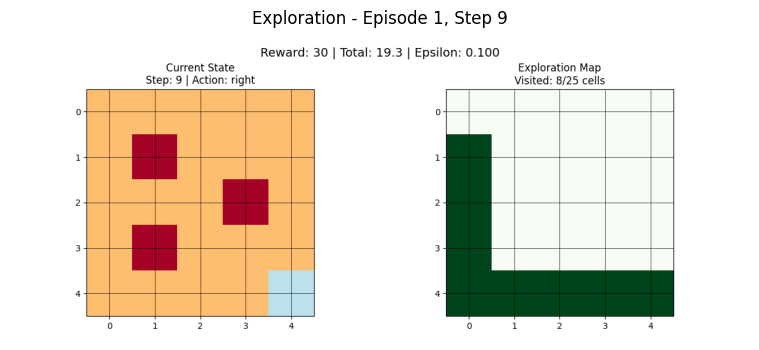

Step 9: right | Reward:   30.0 | Total:   19.3
Position: (4, 4) | Visited: 8 cells
SUCCESS! Found the goal through exploration!
Final coverage: 8/25 cells


In [ ]:
def main():
    # Use a smaller grid so learning doesn't take forever
    GRID_SIZE = 5
    EPISODES = 100

    print("EXPLORATION TRAINING MODE")
    print("The agent has NO idea where the goal is!")
    print("It has to learn to explore efficiently to find it randomly!")

    # Create the environment
    # Note: You'll need to have the GridWorldEnv class defined or imported
    env = GridWorldEnv(
        size=GRID_SIZE,
        goals=[{'pos_init': (GRID_SIZE-1, GRID_SIZE-1), 'moving': False}],
        obstacles=[
            {'pos_init': (1, 1), 'moving': False},
            {'pos_init': (2, 3), 'moving': False},
            {'pos_init': (3, 1), 'moving': False}
        ]
    )

    # Train the agent
    trainer = ExplorationTrainer(env, episodes=EPISODES, max_steps=100)
    results = trainer.train()

    # Show what the agent learned
    print("Animating Learned Exploration Behavior...")
    animator = ExplorationAnimator(results['env'], results['agent'])
    animator.animate(episodes=3, max_steps=40, delay=0.3)

    # Plot the results
    plot_exploration_results(results)

main()